In [1]:
#last 24 hours predict next 1 hour

import pandas as pd
import numpy as np

import os
%matplotlib inline
import math

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

/home/johnsonjzs/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/johnsonjzs/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/johnsonjzs/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/johnsonjzs/.local/lib/python3.5/site-packages/tensorflow/python/framework

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
sess = tf.Session(config = config)

In [3]:
def readTrain():
    path = "./"
    filelist = os.listdir(path)
    for file in filelist:
        if file == 'adasyn-sutherland-past-outages.csv':
            print(file)
            train = pd.read_csv(file)
            
    return train

In [4]:
train = readTrain()
train

adasyn-sutherland-past-outages.csv


,Reason_No outage,Reason_Environmental,Reason_Equipment fault,Reason_Operating fault,Reason_Third party
0,0,0,1,0,0
1,0,0,1,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
6,1,0,0,0,0
7,1,0,0,0,0
8,1,0,0,0,0
9,1,0,0,0,0


In [5]:
def calculate_data(df):
    outage_env = 0
    outage_equip = 0
    outage_3rd = 0
    outage_opfault = 0
    empty_row = 0

    for i in range(len(df)):
        if df.iloc[i]['Reason_Environmental'] != 0:
            outage_env = outage_env + 1
            continue
        elif df.iloc[i]['Reason_Equipment fault'] != 0:
            outage_equip = outage_equip + 1
            continue
        elif df.iloc[i]['Reason_Operating fault'] != 0:
            outage_opfault = outage_opfault + 1
            continue
        elif df.iloc[i]['Reason_Third party'] != 0:
            outage_3rd = outage_3rd + 1
            continue
        else:
            empty_row = empty_row + 1

    print('Number of total row is  : ', len(df), '\n')

    print('Number of Outage row is : ', outage_env + outage_equip + outage_3rd + outage_opfault)
    print('Number of Normal row is : ', empty_row, '\n')

    print('Propotion of Outage is  : ', (outage_env + outage_equip + outage_3rd + outage_opfault) / len(df))
    print('Propotion of Normal is  : ', empty_row / len(df), '\n')
    
    print('Outage cause by is environmental   : ', outage_env)
    print('Outage cause by is equipment fault : ', outage_equip)
    print('Outage cause by is operation fault : ', outage_opfault)
    print('Outage cause by is third party     : ', outage_3rd)

In [7]:
calculate_data(train)

Number of total row is  :  30260 

Number of Outage row is :  24206
Number of Normal row is :  6054 

Propotion of Outage is  :  0.7999339061467283
Propotion of Normal is  :  0.20006609385327165 

Outage cause by is environmental   :  6046
Outage cause by is equipment fault :  6053
Outage cause by is operation fault :  6054
Outage cause by is third party     :  6053


In [6]:
def buildTrain(train, pastDay, futureDay):
    X_train, Y_train = [], []
    for i in range(train.shape[0] - futureDay - pastDay):
        X_train.append(np.array(train.iloc[i: i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay: i+pastDay+futureDay]))
    
    
    return np.array(X_train), np.array(Y_train)

In [7]:
def shuffle(X, Y):
  np.random.seed(10)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [8]:
def splitData(X, Y, rate):
    X_train = X[int(X.shape[0] * rate): ]
    Y_train = Y[int(Y.shape[0] * rate): ]
    X_val = X[: int(X.shape[0] * rate)]
    Y_val = Y[: int(Y.shape[0] * rate)]
    
    return X_train, Y_train, X_val, Y_val

In [9]:
def buildManyToManyModel(shape):
    model = Sequential()
    model.add(LSTM(30, input_shape=(shape[1], shape[2]), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
            
    opt = tf.keras.optimizers.Adam(lr=1e-4)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    model.summary()
  
    return model

In [10]:
train = readTrain()

X_train, Y_train = buildTrain(train, 24, 1)
X_train, Y_train = shuffle(X_train, Y_train)

X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

model = buildManyToManyModel(X_train.shape)

adasyn-sutherland-past-outages.csv
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                4320      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 155       
Total params: 4,475
Trainable params: 4,475
Non-trainable params: 0
_________________________________________________________________


In [11]:
print(X_train.shape)
print(X_val.shape)

(27212, 24, 5)
(3023, 24, 5)


In [12]:
print(Y_train.shape)
print(Y_val.shape)

(27212, 1, 5)
(3023, 1, 5)


In [28]:
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
Y_train = Y_train[:, 0, :] # if many_to_many 就要拿掉這行
Y_val = Y_val[:, 0, :] # if many_to_many 就要拿掉這行

history = model.fit(X_train, Y_train, epochs=128, batch_size=256, validation_data=(X_val, Y_val), callbacks=[callback])

Train on 27212 samples, validate on 3023 samples
Epoch 1/128
27212/27212 [==============================] - 7s 250us/sample - loss: 1.5629 - acc: 0.3231 - val_loss: 1.4731 - val_acc: 0.6044
Epoch 2/128
27212/27212 [==============================] - 6s 213us/sample - loss: 1.3682 - acc: 0.5986 - val_loss: 1.2246 - val_acc: 0.7956
Epoch 3/128
27212/27212 [==============================] - 6s 216us/sample - loss: 1.0605 - acc: 0.8803 - val_loss: 0.8657 - val_acc: 0.9914
Epoch 4/128
27212/27212 [==============================] - 6s 209us/sample - loss: 0.7221 - acc: 0.9865 - val_loss: 0.5665 - val_acc: 0.9917
Epoch 5/128
27212/27212 [==============================] - 6s 210us/sample - loss: 0.4755 - acc: 0.9921 - val_loss: 0.3684 - val_acc: 0.9914
Epoch 6/128
27212/27212 [==============================] - 6s 213us/sample - loss: 0.3144 - acc: 0.9920 - val_loss: 0.2407 - val_acc: 0.9911
Epoch 7/128
27212/27212 [==============================] - 6s 212us/sample - loss: 0.2177 - acc: 0.9917 -

27212/27212 [==============================] - 6s 209us/sample - loss: 0.0235 - acc: 0.9941 - val_loss: 0.0261 - val_acc: 0.9934
Epoch 116/128
27212/27212 [==============================] - 6s 216us/sample - loss: 0.0236 - acc: 0.9942 - val_loss: 0.0259 - val_acc: 0.9934
Epoch 117/128
27212/27212 [==============================] - 6s 212us/sample - loss: 0.0234 - acc: 0.9940 - val_loss: 0.0258 - val_acc: 0.9934
Epoch 118/128
27212/27212 [==============================] - 6s 215us/sample - loss: 0.0228 - acc: 0.9940 - val_loss: 0.0258 - val_acc: 0.9934
Epoch 119/128
27212/27212 [==============================] - 6s 215us/sample - loss: 0.0239 - acc: 0.9942 - val_loss: 0.0258 - val_acc: 0.9934
Epoch 120/128
27212/27212 [==============================] - 6s 212us/sample - loss: 0.0239 - acc: 0.9942 - val_loss: 0.0257 - val_acc: 0.9934
Epoch 121/128
27212/27212 [==============================] - 6s 211us/sample - loss: 0.0233 - acc: 0.9941 - val_loss: 0.0258 - val_acc: 0.9934
Epoch 122/128

In [29]:
model.save('lstm_model_single_layer.h5')

In [ ]:
#---Loss figure-----------

In [30]:
loss = []
x = [float(a) for a in history.history['loss']]
for x in history.history['loss']:
    loss.append(x)

val_loss = []
y = [float(a) for a in history.history['val_loss']]
for y in history.history['val_loss']:
    val_loss.append(y)

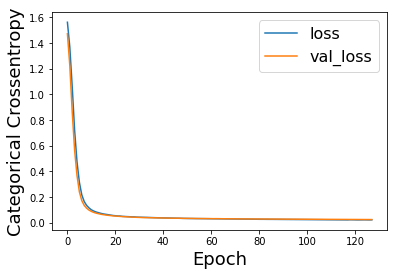

<Figure size 432x288 with 0 Axes>

In [37]:
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xlabel('Epoch',fontsize = 18)
plt.legend(['loss', 'val_loss'], loc='upper right', prop={'size':16})

plt.draw()
plt.show()
fig = plt.gcf()
fig.savefig('LSTM_Single_Layer_Outage_Prediction_Loss.png', dpi = 100)

In [ ]:
#---Acc figure-----------

In [32]:
acc = []
x = [float(a) for a in history.history['acc']]
for x in history.history['acc']:
    acc.append(x)

val_acc = []
y = [float(a) for a in history.history['val_acc']]
for y in history.history['val_acc']:
    val_acc.append(y)

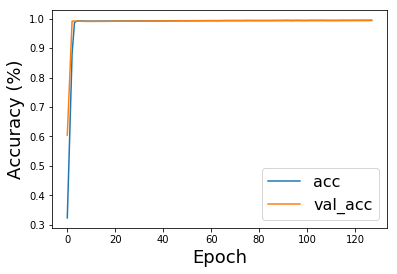

<Figure size 432x288 with 0 Axes>

In [38]:
plt.plot(acc)
plt.plot(val_acc)
plt.ylabel('Accuracy (%)', fontsize = 18)
plt.xlabel('Epoch',fontsize = 18)
plt.legend(['acc', 'val_acc'], loc='lower right', prop={'size':16})

plt.draw()
plt.show()
fig = plt.gcf()
fig.savefig('LSTM_Single_Layer_Outage_Prediction_Accuracy.png', dpi = 100)

In [ ]:
#---Load Test Data-----------

In [11]:
def readTest():
    path = "./"
    filelist = os.listdir(path)
    for file in filelist:
        if file == 'sutherland-past-outages.csv':
            print(file)
            test = pd.read_csv(file)
            test = test.drop(columns=['Start Time', 'Customers Interrupted', 'Duration'])
            
    return test

In [12]:
test = readTest()
test

sutherland-past-outages.csv


,Reason_No outage,Reason_Environmental,Reason_Equipment fault,Reason_Operating fault,Reason_Third party
0,0,0,1,0,0
1,0,0,1,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
6,1,0,0,0,0
7,1,0,0,0,0
8,1,0,0,0,0
9,1,0,0,0,0


In [13]:
X_test, Y_test = buildTrain(test, 24, 1)
Y_test = Y_test[:,0,:]

print(X_test.shape)
print(Y_test.shape)

(6219, 24, 5)
(6219, 5)


In [14]:
from tensorflow.keras.models import load_model
model = load_model('lstm_model_single_layer.h5')
metric = model.evaluate(X_test, Y_test)
metric

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
6219/6219 [==============================] - 5s 832us/sample - loss: 0.0916 - acc: 0.9740


[0.09159176270377888, 0.9739508]

In [15]:
Y_predict = model.predict(X_test)

In [16]:
Y_predict

array([[9.9027026e-01, 5.3012627e-03, 3.2604488e-03, 2.9230106e-04,
        8.7583560e-04],
       [9.9035966e-01, 5.2412855e-03, 3.2413637e-03, 2.8596888e-04,
        8.7177625e-04],
       [9.9041361e-01, 5.2048326e-03, 3.2298202e-03, 2.8211402e-04,
        8.6971518e-04],
       ...,
       [9.9041361e-01, 5.2048326e-03, 3.2298202e-03, 2.8211402e-04,
        8.6971518e-04],
       [9.9041361e-01, 5.2048326e-03, 3.2298202e-03, 2.8211402e-04,
        8.6971518e-04],
       [6.4137912e-01, 7.1032636e-02, 2.7620998e-01, 3.0489205e-03,
        8.3293682e-03]], dtype=float32)

In [34]:
Y_predict.shape

(6219, 5)

In [39]:
num_classes = 5
Y_predict = tf.argmax(Y_predict, axis = 1)
Y_test = tf.argmax(Y_test, axis = 1)

In [41]:
#X-axis is Predict
#Y-axis is True label

confusion_matrix = tf.confusion_matrix(Y_test, Y_predict, num_classes)
with tf.Session() as sess:
    print(confusion_matrix.eval())

Instructions for updating:
Use tf.cast instead.
[[5985   24   21    0    2]
 [  55   39    0    0    0]
 [  45    2   27    0    0]
 [   2    0    0    0    0]
 [  11    0    0    0    6]]
